# Part 8 Forward modelling and optimization of soil and snow properties using the airborne UMass Ku-Band radar backscatter data.
[Benoit Montpetit](https://github.com/ecccben), *CPS/CRD/ECCC*, 2024  
[Mike Brady](https://github.com/m9brady), *CPS/CRD/ECCC*, 2024

Here, we use the Ku-Band (Airborne UMass) radar backscatter data to optimize the background soil properties and the microwave grain snow grain size (via polydispersity, [see Picard et al. (2022)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021AV000630)) using SMRT, the Improved Born Approximation (IBA) scattering model and the exponential autocorrelation function and the Geometrical Optics background surface scattering model.

In [1]:
import geopandas as gp
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.optimize import least_squares
from scipy.interpolate import interp1d
from smrt.core.globalconstants import PERMITTIVITY_OF_AIR
from smrt import sensor_list, make_soil, make_model, make_snowpack
from smrt.substrate.reflector_backscatter import make_reflector
from matplotlib import pyplot as plt
import matplotlib

font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)
plt.rcParams["axes.labelsize"] = 22
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16

import pickle

pd.set_option('use_inf_as_na', True)

from radarfunc import to_dB

# Loading the optimized background values from C- and X-Band

In [2]:
background = pd.read_pickle(r'data/TVC_background_CX-Band.pkl')
background

,site,epsr_c,epsi_c,epsr_x,epsi_x,mss,lsq
0,all,2.466008,0.004518,2.606789,0.006038,0.010198,5984.775888
1,RP16,2.068339,0.000499,2.187264,0.001095,0.009505,15.118812
2,RP17,2.638995,0.003530,2.762957,0.003322,0.009669,7.158915
3,RP18,2.580436,0.003229,2.755940,0.004118,0.009661,4.049906
4,RP19,3.029246,0.006728,3.149412,0.006220,0.016802,0.023757
5,RP20,2.402191,0.002483,2.541286,0.002977,0.008981,5.793995
6,RP21,2.562950,0.003417,2.659355,0.003605,0.010581,4.276721
7,RP22,2.552231,0.003429,2.589926,0.003236,0.011585,3.376985
8,RP23,2.520022,0.003225,2.528385,0.002909,0.008735,4.078824
9,RP24,2.396187,0.002263,2.550421,0.003154,0.007307,7.587102


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>site</th>
      <th>epsr_c</th>
      <th>epsi_c</th>
      <th>epsr_x</th>
      <th>epsi_x</th>
      <th>mss</th>
      <th>lsq</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>all</td>
      <td>2.466008</td>
      <td>0.004518</td>
      <td>2.606789</td>
      <td>0.006038</td>
      <td>0.010198</td>
      <td>5984.775888</td>
    </tr>
    <tr>
      <th>1</th>
      <td>RP16</td>
      <td>2.068339</td>
      <td>0.000499</td>
      <td>2.187264</td>
      <td>0.001095</td>
      <td>0.009505</td>
      <td>15.118812</td>
    </tr>
    <tr>
      <th>2</th>
      <td>RP17</td>
      <td>2.638995</td>
      <td>0.003530</td>
      <td>2.762957</td>
      <td>0.003322</td>
      <td>0.009669</td>
      <td>7.158915</td>
    </tr>
    <tr>
      <th>3</th>
      <td>RP18</td>
      <td>2.580436</td>
      <td>0.003229</td>
      <td>2.755940</td>
      <td>0.004118</td>
      <td>0.009661</td>
      <td>4.049906</td>
    </tr>
    <tr>
      <th>4</th>
      <td>RP19</td>
      <td>3.029246</td>
      <td>0.006728</td>
      <td>3.149412</td>
      <td>0.006220</td>
      <td>0.016802</td>
      <td>0.023757</td>
    </tr>
    <tr>
      <th>5</th>
      <td>RP20</td>
      <td>2.402191</td>
      <td>0.002483</td>
      <td>2.541286</td>
      <td>0.002977</td>
      <td>0.008981</td>
      <td>5.793995</td>
    </tr>
    <tr>
      <th>6</th>
      <td>RP21</td>
      <td>2.562950</td>
      <td>0.003417</td>
      <td>2.659355</td>
      <td>0.003605</td>
      <td>0.010581</td>
      <td>4.276721</td>
    </tr>
    <tr>
      <th>7</th>
      <td>RP22</td>
      <td>2.552231</td>
      <td>0.003429</td>
      <td>2.589926</td>
      <td>0.003236</td>
      <td>0.011585</td>
      <td>3.376985</td>
    </tr>
    <tr>
      <th>8</th>
      <td>RP23</td>
      <td>2.520022</td>
      <td>0.003225</td>
      <td>2.528385</td>
      <td>0.002909</td>
      <td>0.008735</td>
      <td>4.078824</td>
    </tr>
    <tr>
      <th>9</th>
      <td>RP24</td>
      <td>2.396187</td>
      <td>0.002263</td>
      <td>2.550421</td>
      <td>0.003154</td>
      <td>0.007307</td>
      <td>7.587102</td>
    </tr>
    <tr>
      <th>10</th>
      <td>RP25</td>
      <td>2.280866</td>
      <td>0.001550</td>
      <td>2.492229</td>
      <td>0.002649</td>
      <td>0.009302</td>
      <td>5.336857</td>
    </tr>
    <tr>
      <th>11</th>
      <td>RP26</td>
      <td>2.463236</td>
      <td>0.001976</td>
      <td>2.600816</td>
      <td>0.003294</td>
      <td>0.009951</td>
      <td>4.996285</td>
    </tr>
    <tr>
      <th>12</th>
      <td>RP27</td>
      <td>2.258602</td>
      <td>0.001594</td>
      <td>2.258805</td>
      <td>0.001476</td>
      <td>0.007965</td>
      <td>2.357273</td>
    </tr>
    <tr>
      <th>13</th>
      <td>RP28</td>
      <td>2.741816</td>
      <td>0.004625</td>
      <td>2.778596</td>
      <td>0.004239</td>
      <td>0.012673</td>
      <td>8.556674</td>
    </tr>
    <tr>
      <th>14</th>
      <td>RP29</td>
      <td>2.603640</td>
      <td>0.003607</td>
      <td>2.740354</td>
      <td>0.004036</td>
      <td>0.013251</td>
      <td>5.667158</td>
    </tr>
    <tr>
      <th>15</th>
      <td>RP30</td>
      <td>2.652969</td>
      <td>0.004729</td>
      <td>2.885955</td>
      <td>0.005293</td>
      <td>0.013267</td>
      <td>4.351416</td>
    </tr>
    <tr>
      <th>16</th>
      <td>RP31</td>
      <td>2.295109</td>
      <td>0.001829</td>
      <td>2.596983</td>
      <td>0.003273</td>
      <td>0.008949</td>
      <td>2.740762</td>
    </tr>
    <tr>
      <th>17</th>
      <td>SD02</td>
      <td>2.628416</td>
      <td>0.002634</td>
      <td>2.948112</td>
      <td>0.005140</td>
      <td>0.010893</td>
      <td>11.317456</td>
    </tr>
    <tr>
      <th>18</th>
      <td>SM02</td>
      <td>2.322261</td>
      <td>0.001816</td>
      <td>2.443560</td>
      <td>0.002458</td>
      <td>0.010899</td>
      <td>7.389861</td>
    </tr>
    <tr>
      <th>19</th>
      <td>SO02</td>
      <td>2.543608</td>
      <td>0.003346</td>
      <td>2.395109</td>
      <td>0.002200</td>
      <td>0.010224</td>
      <td>2.370258</td>
    </tr>
    <tr>
      <th>20</th>
      <td>ST02</td>
      <td>2.270314</td>
      <td>0.001693</td>
      <td>2.381293</td>
      <td>0.002127</td>
      <td>0.008869</td>
      <td>3.952208</td>
    </tr>
    <tr>
      <th>21</th>
      <td>SV02</td>
      <td>2.499894</td>
      <td>0.003228</td>
      <td>2.503828</td>
      <td>0.002810</td>
      <td>0.010368</td>
      <td>2.797720</td>
    </tr>
  </tbody>
</table>
</div>

# Interpolating the initial soil permittivity from C- and X-Band retrieved permittivity

In [6]:
p = interp1d([5.405e9,9.65e9],
             [complex(background.loc[0].epsr_c, background.loc[0].epsi_c), 
              complex(background.loc[0].epsr_x, background.loc[0].epsi_x)],
             fill_value="extrapolate")

eps_ku = p(13.25e9)

soil_params=[float(np.real(eps_ku)), float(np.imag(eps_ku)), background.mss.loc[0]]
pd.DataFrame({'epsr':[float(np.real(eps_ku))], 'epsi':[float(np.imag(eps_ku))], 'mss':[background.mss.loc[0]]}, index=['Ku-Band'])

,epsr,epsi,mss
Ku-Band,2.72618,0.007328,0.010198


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>epsr</th>
      <th>epsi</th>
      <th>mss</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Ku-Band</th>
      <td>2.72618</td>
      <td>0.007328</td>
      <td>0.010198</td>
    </tr>
  </tbody>
</table>
</div>

Importing list of sites for the January TVC campaign. Remove the SC (calibration target site) site where a corner reflector was within the 100m footprint which artificially boosted the backscatter signal.

In [7]:
from constants import TVC02
sites = pd.DataFrame({'site':TVC02})
sites.site.replace({'RS':'RP'}, regex=True, inplace=True)
sites=list(sites.site.values)
sites.remove('SC02')

# Load modal pit data

In [8]:
df_pits_mode = pd.read_pickle(r'data/df_pits_mode.pkl')

# SMRT simulator function

In [33]:
def smrtSim(f, theta, thickness, density, temperature, p_ex, kappa_ws, kappa_dh, grain_type, soil_params, bands=['vv']):
    
    '''
    f: frequency (in Hz)
    theta: incidence angle (in degrees)
    thickness: list of snow layer thicknesses (in m)
    density: list of snow layer densities (in kg/m3)
    temperature: list of snow layer temperatures (in K)
    p_ex: list of snow layer exponential correlation lengths (in m)
    kappa_ws: polydispersity for the rounded grain snow type (Arctic wind slab)
    kapp_dh: polydispersity for the depth hoar snow grain type
    grain_type: classified snow layer grain types (R: rounded grains; H: depth hoar)
    soil_params: list of background soil properties
        epsr: real part of the soil permittivity
        epsi: imaginary part of the soil permittivity
        mss: mean square slope soil roughness parameter
    bands: polarizations
    '''
    
    #Modeling theories to use in SMRT
    model = make_model("iba", "dort", rtsolver_options = {'m_max': 2, 'error_handling':'nan', 'phase_normalization' : True})
    
    #Initializing the modeled sigma-nought values
    sim_sig0 = {}
    
    #Creating the substrate under the snowpack
    '''
    Roughness model: Geometrical Optics Backscatter model
    Permittivity model: static complexe permittivity values to optimize
    Mean_square_slope: Mean Square Slope calculated previously (mss, no units)
    Temperature: Soil temperature (in K)
    '''
    sub = make_soil('geometrical_optics', 
                    permittivity_model = complex(soil_params[0],soil_params[1]), 
                    mean_square_slope=soil_params[2], 
                    temperature = 253.7)
    
    kappa = np.array([kappa_ws] * len(grain_type))
    kappa[np.where(grain_type=='H')[0]] = kappa_dh
    
    #Creating the snowpack to simulate with the substrate
    sp = make_snowpack(thickness=thickness, 
                       microstructure_model='exponential',
                       density= density,
                       temperature=temperature,
                       ice_permittivity_model=None,
                       background_permittivity_model=PERMITTIVITY_OF_AIR,
                       liquid_water=0, salinity=0, 
                       corr_length = kappa * p_ex,
                       substrate = sub)

    #Initializing the outputs dataframe
    sim_sig0=pd.DataFrame({'theta': [], 'sig0': []})

    sensor  = sensor_list.active(f, theta)

    sigma_nought = model.run(sensor, sp, parallel_computation=True)
    
    for tet in theta:
    
        for band in bands:

            sim_sig0 = pd.concat([sim_sig0,pd.DataFrame({'theta': [np.array(tet)], 
                                                         'pol':[band],
                                                         'sig0': [sigma_nought.sigma_as_dataframe().loc[
                                                                  tet,band[0].upper(),band[1].upper()].sigma],
                                                         'other_data':[sigma_nought.other_data]})], 
                                 ignore_index=True)

    return sim_sig0

# Loading the Ku-band data and isolating only the January campaign measurements

In [10]:
KuBand = pd.read_pickle(r"data/radar_site_stats.pkl")
KuBand = KuBand[(KuBand['radar_ts']<=datetime(2019,2,1)) & (KuBand['radar_ts']>=datetime(2019,1,1)) & (KuBand['site_id'].isin(sites))]

In [17]:
print('Site & Number of measurements & angle range\\\\')
for site in sites:

    ku_temp = KuBand[KuBand['site_id']==site]
    print(site + ' & ' + "{:.0f}".format(len(ku_temp)) + ' & ' + "{:.1f}".format(ku_temp.inc_mean.min()) + ' - ' + "{:.1f}".format(ku_temp.inc_mean.max()) + '\\\\')

Site & Number of measurements & angle range\\
RP16 & 24 & 21.1 - 69.0\\
RP17 & 38 & 18.8 - 64.9\\
RP18 & 35 & 19.7 - 71.9\\
RP19 & 37 & 17.9 - 70.2\\
RP20 & 37 & 17.9 - 61.0\\
RP21 & 28 & 18.9 - 69.8\\
RP22 & 35 & 18.8 - 76.0\\
RP23 & 19 & 19.3 - 64.9\\
RP24 & 16 & 19.0 - 52.7\\
RP25 & 22 & 17.5 - 65.3\\
RP26 & 11 & 20.1 - 51.0\\
RP27 & 12 & 17.7 - 63.6\\
RP28 & 11 & 21.1 - 60.2\\
RP29 & 13 & 18.2 - 61.0\\
RP30 & 9 & 19.6 - 53.1\\
RP31 & 8 & 23.3 - 76.1\\
SD02 & 37 & 19.7 - 70.9\\
SM02 & 36 & 19.3 - 64.3\\
SO02 & 31 & 18.8 - 62.5\\
ST02 & 32 & 19.1 - 57.1\\
SV02 & 35 & 22.4 - 80.3\\


# Optimization function
Function that calculates the difference between the simulated and measured $\sigma^0$.  
This function will be used by the `least_squares` function

In [31]:
def opti_backsnow(param2opti, df_pits, thetas, sig0, soil_params, sites, ku_sites):
    
    delta = np.array([])
    
    for site in sites:
    
        sim_sig0 = smrtSim(13.25e9, thetas[ku_sites==site], 
                           df_pits[site]['thickness'], 
                           df_pits[site]['density'], 
                           df_pits[site]['temperature'], 
                           df_pits[site]['p_ex'], 
                           param2opti[0],param2opti[1],
                           df_pits[site]['grain_type'],
                           np.append(param2opti[-2:], soil_params[2]))

        if to_dB(sim_sig0.sig0).isnull().any():
            print(param2opti[0])
            print(param2opti[1])

        if not to_dB(sim_sig0.sig0).isnull().any():

            delta = np.append(delta, to_dB(sig0[ku_sites==site].values)-to_dB(sim_sig0.sig0.values))

        else:

            delta = np.append(delta, [999] * len(sig0[ku_sites==site].values))
            
    print('K_ws = ' + "{:.2f}".format(param2opti[0]) +
          '; K_dh = ' + "{:.2f}".format(param2opti[1]) +
          '; epsr = ' + "{:.2f}".format(param2opti[2]) +
          '; epsi = ' + "{:.4f}".format(param2opti[3]) +
          '; lsq = ' + "{:.3f}".format(np.sum(delta**2)))
    
    return delta

# Creating initial conditions
Incidence angle range was limited to 20 to 65 degrees. SMRT has difficulties converging to a solution beyond that range. The range selected is larger than what is proposed by the future Canadian Terrestrial Snow Mass Mission

In [19]:
thetas = KuBand['inc_mean']
sig0 = KuBand['slc0_sig0_filt']
ku_sites = KuBand['site_id']
sig0 = sig0[(thetas>=20) & (thetas<=65)]
ku_sites = ku_sites[(thetas>=20) & (thetas<=65)]
thetas = thetas[(thetas>=20) & (thetas<=65)]

In [34]:
param2opti = [0.75,1.09,soil_params[0], soil_params[1]]
bounds = ([0.5,1,2.3,0.0001], [1,2,5,0.5])  

results_ku1={}

for site in sites:
    
    print(site)

    results_ku1[site] = least_squares(opti_backsnow, param2opti, 
                            args=(df_pits_mode, thetas, sig0, soil_params,[site],ku_sites), 
                            bounds=bounds,
                            ftol=1e-1,
                            method='trf')

RP16
K_ws = 0.75; K_dh = 1.09; epsr = 2.73; epsi = 0.0073; lsq = 57.110
K_ws = 0.75; K_dh = 1.09; epsr = 2.73; epsi = 0.0073; lsq = 57.110
K_ws = 0.75; K_dh = 1.09; epsr = 2.73; epsi = 0.0073; lsq = 57.110
K_ws = 0.75; K_dh = 1.09; epsr = 2.73; epsi = 0.0073; lsq = 57.110
K_ws = 0.75; K_dh = 1.09; epsr = 2.73; epsi = 0.0073; lsq = 57.110
K_ws = 0.76; K_dh = 1.13; epsr = 3.01; epsi = 0.0691; lsq = 26.032
K_ws = 0.76; K_dh = 1.13; epsr = 3.01; epsi = 0.0691; lsq = 26.032
K_ws = 0.76; K_dh = 1.13; epsr = 3.01; epsi = 0.0691; lsq = 26.032
K_ws = 0.76; K_dh = 1.13; epsr = 3.01; epsi = 0.0691; lsq = 26.032
K_ws = 0.76; K_dh = 1.13; epsr = 3.01; epsi = 0.0691; lsq = 26.032
K_ws = 0.73; K_dh = 1.01; epsr = 3.20; epsi = 0.1156; lsq = 23.929
K_ws = 0.73; K_dh = 1.01; epsr = 3.20; epsi = 0.1156; lsq = 23.929
K_ws = 0.73; K_dh = 1.01; epsr = 3.20; epsi = 0.1156; lsq = 23.929
K_ws = 0.73; K_dh = 1.01; epsr = 3.20; epsi = 0.1156; lsq = 23.929
K_ws = 0.73; K_dh = 1.01; epsr = 3.20; epsi = 0.1156; lsq

In [52]:
k_ws=[]
k_dh=[]
epsr=[]
epsi=[]
for site in sites:

    k_ws.append(results_ku1[site].x[0])
    k_dh.append(results_ku1[site].x[1])
    epsr.append(results_ku1[site].x[2])
    epsi.append(results_ku1[site].x[3])

In [42]:
df = pd.DataFrame()

for key in results_ku1.keys():

    df = pd.concat([df, pd.DataFrame({'site':[key],'kappa_r':[results_ku1[key].x[0]],
                                     'kappa_h':[results_ku1[key].x[1]],'epsr_ku':[results_ku1[key].x[2]],
                                     'epsi_ku':[results_ku1[key].x[0]],'lsq':[results_ku1[key].cost]})], ignore_index=True)
    

In [45]:
print(df.iloc[:,1:-1].median())
print(df.iloc[:,1:-1].std())

kappa_r    0.740648
kappa_h    1.110745
epsr_ku    2.767381
epsi_ku    0.740648
dtype: float64
kappa_r    0.148694
kappa_h    0.255006
epsr_ku    0.747658
epsi_ku    0.148694
dtype: float64


In [46]:
df

,site,kappa_r,kappa_h,epsr_ku,epsi_ku,lsq
0,RP16,0.729926,1.009364,3.202873,0.729926,11.964269
1,RP17,0.927286,1.748782,4.076946,0.927286,9.580219
2,RP18,0.826597,1.346364,4.124440,0.826597,8.730677
3,RP19,0.984158,1.970670,3.895321,0.984158,12.386753
4,RP20,0.830264,1.391852,3.584707,0.830264,10.647871
5,RP21,0.733628,1.206275,3.741716,0.733628,5.180657
6,RP22,0.778822,1.207923,3.702007,0.778822,10.110723
7,RP23,0.520968,1.071239,3.995013,0.520968,5.250060
8,RP24,0.800592,1.273255,3.598643,0.800592,3.544571
9,RP25,0.516313,1.006122,2.324468,0.516313,6.331697


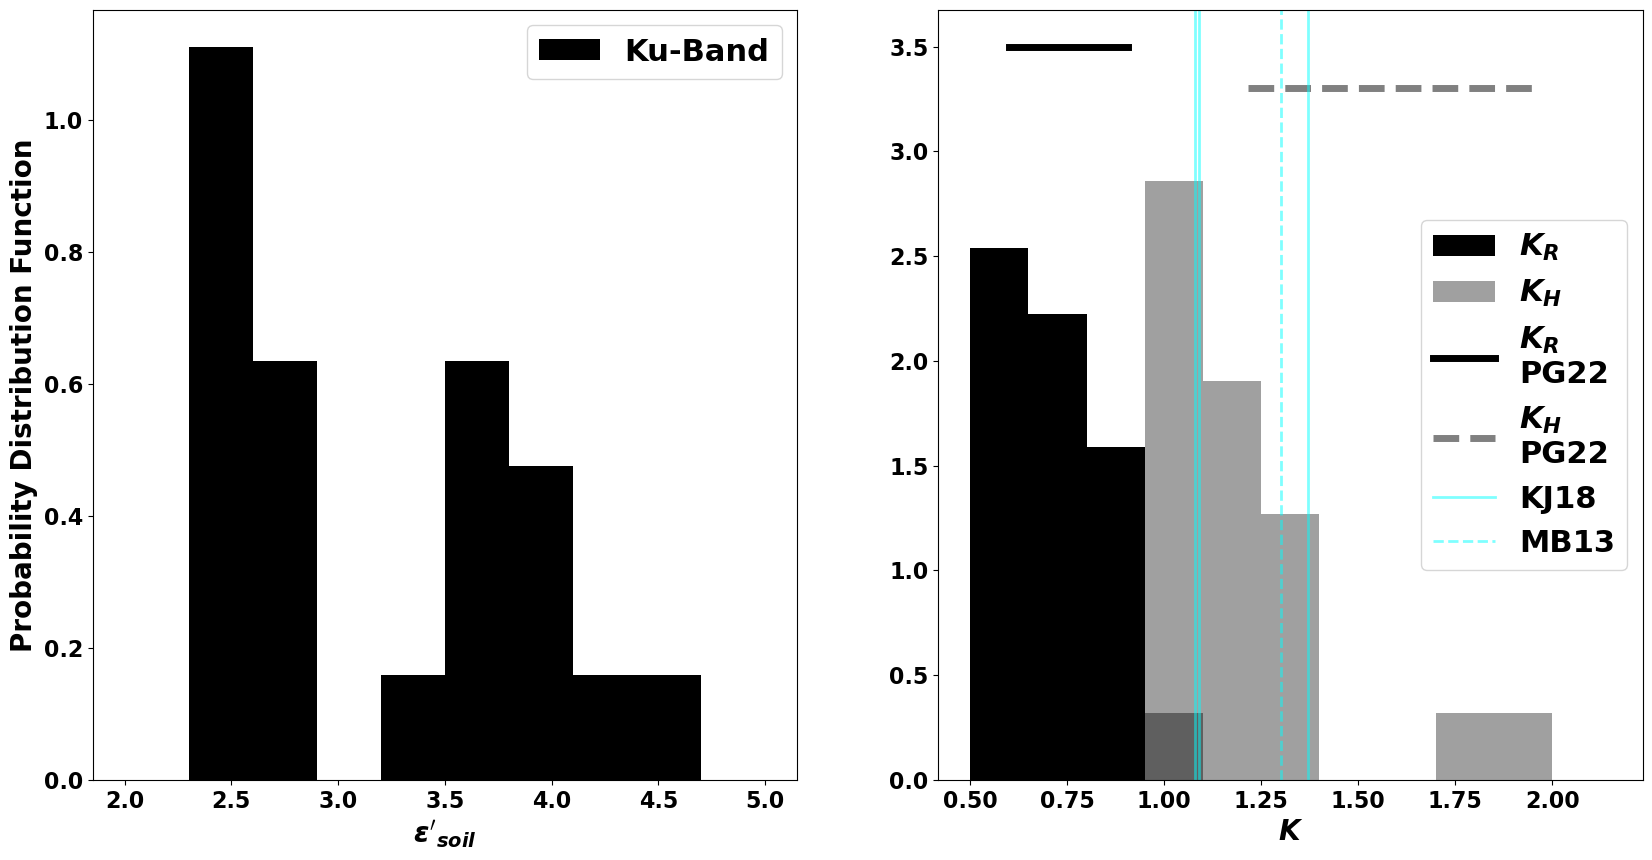

In [39]:
fig, ax = plt.subplots(1,2,figsize=(20, 10))

ax[0].hist(df.iloc[:-1].epsr_ku, bins=np.arange(2,5.3,0.3), density=True, label = 'Ku-Band', color='k')
ax[1].hist(df.iloc[:-1].kappa_r, bins=np.arange(0.5,2.2,0.15), density=True, label = '$K_R$', color='k')
ax[1].hist(df.iloc[:-1].kappa_h, bins=np.arange(0.5,2.2,0.15), density=True, label = '$K_H$', color='grey', alpha=0.75)
ax[1].axhline(3.5, xmin=0.1, xmax=0.27, linestyle='-', color='k', label='$K_R$ \nPG22',linewidth=5)
ax[1].axhline(3.3, xmin=0.44, xmax=0.85, linestyle='--', color='grey', label='$K_H$ \nPG22',linewidth=5)
ax[1].axvline(1.08, linestyle='-', color='cyan', label='KJ18',linewidth=2,alpha=0.5)
ax[1].axvline(1.09, linestyle='-', color='cyan',linewidth=2,alpha=0.5)
ax[1].axvline(1.37, linestyle='-', color='cyan',linewidth=2,alpha=0.5)
ax[1].axvline(1.3, linestyle='--', color='cyan', label='MB13',linewidth=2,alpha=0.5)

ax[0].set_ylabel('Probability Distribution Function', fontsize=20, fontweight='bold')
ax[0].set_xlabel('$\epsilon\'_{soil}$', fontsize=20, fontweight='bold')
ax[1].set_xlabel('$K$', fontsize=20, fontweight='bold')
ax[0].legend()
ax[1].legend()


<center><img src="Figures/Figure12.png" Width="1000px"></center>

Figure 12 of [Montpetit et al., (2024)](link TBD): Distribution of retrieved parameters at Ku-Band (Table 7). The range of retrieved *K* values from [Picard et al. (2022)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021AV000630) for both
grain types (PG22) and the different values retrieved by [King et al. (2018)](https://www.sciencedirect.com/science/article/pii/S003442571830258X?via%3Dihub) and [Montpetit et al. (2013)](https://ieeexplore.ieee.org/document/6507560) are also displayed (KJ18 and MB13
respectively).

In [56]:
epsr_temp=[]
for site in results_ku1.keys():
    epsr_temp.append(results_ku1[site].x[2])
print('epsr STD = ' + str(np.std(epsr_temp)))
print('min epsr = ' + str(np.min(epsr_temp)))
print('max epsr = ' + str(np.max(epsr_temp)))

epsr STD = 0.7143338210207454
min epsr = 2.3002943384102394
max epsr = 4.522847269028935


***********************************

# Simulating the Ku-Band $\sigma^0$ using the retrieved parameters

Simulating the $\sigma^0$ using the site specific retrieved parameters.

In [58]:
sim_sig0={}

for site in sites:
    
    sim_sig0[site]={}

    sim_sig0[site] = smrtSim(13.25e9, thetas[ku_sites==site], 
                                  df_pits_mode[site]['thickness'], 
                                  df_pits_mode[site]['density'], 
                                  df_pits_mode[site]['temperature'], 
                                  df_pits_mode[site]['p_ex'],
                                  results_ku1[site].x[0],results_ku1[site].x[1],
                                  df_pits_mode[site]['grain_type'],
                                np.append(results_ku1[site].x[-2:],soil_params[2]))

Simulating the $\sigma^0$ using the median values of the retrieved parameters from all sites.

In [59]:
sim_sig0['med']={}

for site in sites:
    
    sim_sig0['med'][site]={}

    sim_sig0['med'][site] = smrtSim(13.25e9, thetas[ku_sites==site], 
                                  df_pits_mode[site]['thickness'], 
                                  df_pits_mode[site]['density'], 
                                  df_pits_mode[site]['temperature'], 
                                  df_pits_mode[site]['p_ex'],
                                  df.iloc[:,1:-1].kappa_r.median(),df.iloc[:,1:-1].kappa_h.median(),
                                  df_pits_mode[site]['grain_type'],
                                np.append([df.iloc[:,1:-1].epsr_ku.median(),df.iloc[:,1:-1].epsi_ku.median()],soil_params[2]))

RP16
RP17
RP18
RP19
RP20
RP21
RP22
RP23
RP24
RP25
RP26
RP27
RP28
RP29
RP30
RP31
SD02
SM02
SO02
ST02
SV02


Simulating the $\sigma^0$ using the median values of the two distribution of $\varepsilon'_{soil}$ and the median values of $K$ for both grain types retrieved from all sites.

In [61]:
sim_sig0['med-dual']={}

sites_dual = df.loc[(df.epsr_ku<3)].site.values

for site in list(sites_dual):
    
    sim_sig0['med-dual'][site]={}

    sim_sig0['med-dual'][site] = smrtSim(13.25e9, thetas[ku_sites==site], 
                                  df_pits_mode[site]['thickness'], 
                                  df_pits_mode[site]['density'], 
                                  df_pits_mode[site]['temperature'], 
                                  df_pits_mode[site]['p_ex'],
                                  df.iloc[:,1:-1].kappa_r.median(),df.iloc[:,1:-1].kappa_h.median(),
                                  df_pits_mode[site]['grain_type'],
                                np.append([np.median(df.loc[(df.epsr_ku<3)].epsr_ku.values),
                                           np.median(df.loc[(df.epsr_ku<3)].epsi_ku.values)],soil_params[2]))
    
sites_dual = df.loc[(df.epsr_ku>3)].site.values

for site in list(sites_dual):
    
    sim_sig0['med-dual'][site]={}

    sim_sig0['med-dual'][site] = smrtSim(13.25e9, thetas[ku_sites==site], 
                                  df_pits_mode[site]['thickness'], 
                                  df_pits_mode[site]['density'], 
                                  df_pits_mode[site]['temperature'], 
                                  df_pits_mode[site]['p_ex'], 
                                  df.iloc[:,1:-1].kappa_r.median(),df.iloc[:,1:-1].kappa_h.median(),
                                  df_pits_mode[site]['grain_type'],
                                np.append([np.median(df.loc[(df.epsr_ku>3)].epsr_ku.values),
                                           np.median(df.loc[(df.epsr_ku>3)].epsi_ku.values)],soil_params[2]))

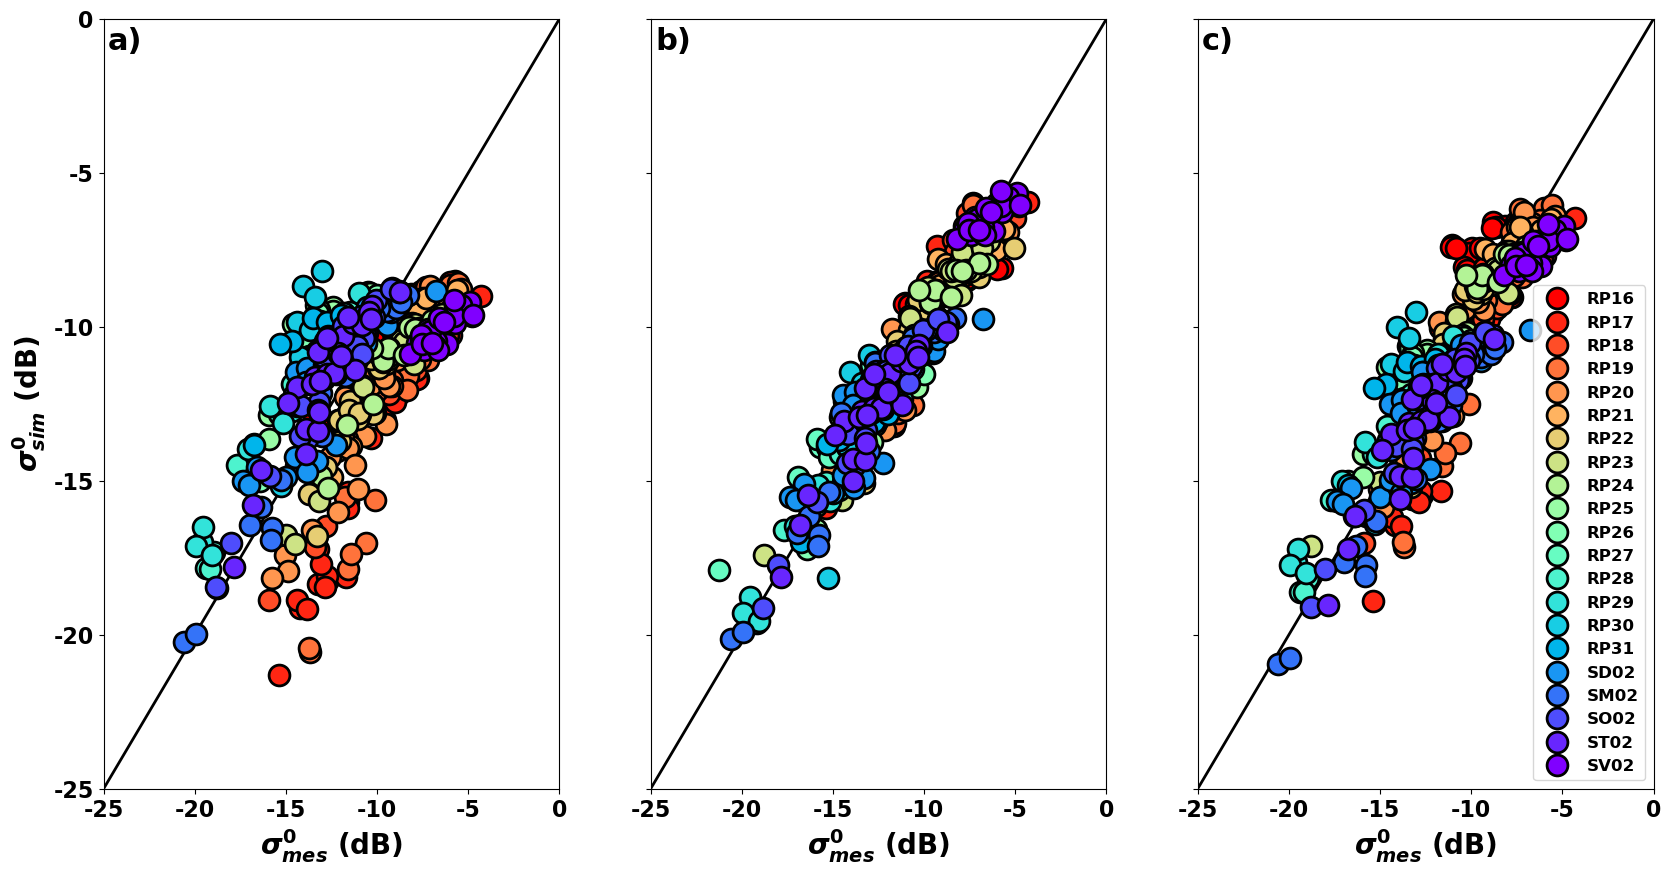

In [83]:
cmap = plt.get_cmap('rainbow')

colors = cmap(np.linspace(0,1,len(sites)))[::-1]

fig, ax = plt.subplots(1,3,figsize=(20, 10))

ax[0].plot([-45, 5],[-45, 5],'-k',linewidth=2)
ax[1].plot([-45, 5],[-45, 5],'-k',linewidth=2)
ax[2].plot([-45, 5],[-45, 5],'-k',linewidth=2)

i=0

deltas=[]
deltas_all=[]
deltas_med=[]

for site in sites:

    j=0
    delta=[]
    delta_all=[]
    
    if j==0:
        
        ax[1].plot(to_dB(sig0[ku_sites==site]), to_dB(sim_sig0[site].sig0),
                'o', markersize=15, markerfacecolor=colors[i], markeredgecolor='k',  markeredgewidth=2,
                label=site,alpha=1)
        
        ax[0].plot(to_dB(sig0[ku_sites==site]), to_dB(sim_sig0['med'][site].sig0),
                'o', markersize=15, markerfacecolor=colors[i], markeredgecolor='k',  markeredgewidth=2,
                label=site,alpha=1)
        
        ax[2].plot(to_dB(sig0[ku_sites==site]), to_dB(sim_sig0['med-dual'][site].sig0),
                'o', markersize=15, markerfacecolor=colors[i], markeredgecolor='k',  markeredgewidth=2,
                label=site,alpha=1)
        
    else:
        
        ax[1].plot(to_dB(sig0[ku_sites==site]), to_dB(sim_sig0[site].sig0),
                'o', markersize=15, markerfacecolor=colors[i], markeredgecolor='k',  markeredgewidth=2,
                label='',alpha=1)
        ax[0].plot(to_dB(sig0[ku_sites==site]), to_dB(sim_sig0['med'][site].sig0),
                'o', markersize=15, markerfacecolor=colors[i], markeredgecolor='k',  markeredgewidth=2,
                label='',alpha=1)
        
        ax[2].plot(to_dB(sig0[ku_sites==site]), to_dB(sim_sig0['med-dual'][site].sig0),
                'o', markersize=15, markerfacecolor=colors[i], markeredgecolor='k',  markeredgewidth=2,
                label='',alpha=1)
        
    j+=1

    deltas.extend((to_dB(sig0[ku_sites==site]).values-
                                to_dB(sim_sig0[site].sig0.values))[~np.isnan(sim_sig0[site].sig0.values)])
    deltas_all.extend((to_dB(sig0[ku_sites==site]).values-
                                to_dB(sim_sig0['med'][site].sig0.values))[~np.isnan(sim_sig0['med'][site].sig0.values)])
    deltas_med.extend((to_dB(sig0[ku_sites==site]).values-
                                to_dB(sim_sig0['med-dual'][site].sig0.values))[~np.isnan(sim_sig0['med-dual'][site].sig0.values)])
        
    i+=1

ax[0].set_xlabel('$\sigma^0_{mes}$ (dB)', fontsize=20, fontweight='bold')
ax[1].set_xlabel('$\sigma^0_{mes}$ (dB)', fontsize=20, fontweight='bold')
ax[2].set_xlabel('$\sigma^0_{mes}$ (dB)', fontsize=20, fontweight='bold')
ax[0].set_ylabel('$\sigma^0_{sim}$ (dB)', fontsize=20, fontweight='bold')
ax[0].set_ylim([-25,0])
ax[0].set_yticks(np.arange(-25,1,5))
ax[0].set_yticklabels(np.arange(-25,1,5).tolist(), fontsize=16, fontweight='bold')
ax[0].set_xlim([-25,0])
ax[0].set_xticks(np.arange(-25,1,5))
ax[0].set_xticklabels(np.arange(-25,1,5).tolist(), fontsize=16, fontweight='bold')
ax[1].set_ylim([-25,0])
ax[1].set_yticks(np.arange(-25,1,5))
ax[1].set_yticklabels('', fontsize=16, fontweight='bold')
ax[1].set_xlim([-25,0])
ax[1].set_xticks(np.arange(-25,1,5))
ax[1].set_xticklabels(np.arange(-25,1,5).tolist(), fontsize=16, fontweight='bold')
ax[2].set_ylim([-25,0])
ax[2].set_yticks(np.arange(-25,1,5))
ax[2].set_yticklabels('', fontsize=16, fontweight='bold')
ax[2].set_xlim([-25,0])
ax[2].set_xticks(np.arange(-25,1,5))
ax[2].set_xticklabels(np.arange(-25,1,5).tolist(), fontsize=16, fontweight='bold')

ax[0].text(-24.75,-1,'a)')
ax[1].text(-24.75,-1,'b)')
ax[2].text(-24.75,-1,'c)')
ax[2].legend(loc=4, fontsize=12)

In [82]:
(to_dB(sig0[ku_sites==site]).values-
                                to_dB(sim_sig0[site].sig0.values))[~np.isnan(sim_sig0[site].sig0.values)]

array([ 0.17571458, -0.65091995, -1.85602935, -0.35459821,  0.8490662 ,
        0.34350857,  0.50069953,  0.41437299, -0.66306011, -1.83421992,
        0.8595656 ,  2.37142925, -0.81311452, -0.44789316, -0.12241099,
       -0.06804836, -0.19708355, -1.52316116, -0.23408846,  2.13580652,
        0.77240259, -0.14903297])

<center><img src="Figures/Figure13.png" Width="1000px"></center>

Figure 13 of [Montpetit et al., (2024)](link TBD): Comparison between simulated and measured $\sigma^0$ at Ku-Band for a) using a single set of parameters for all sites (Table 7), b)
retrieved parameters for each site individually (distributed values shown in Figure 12) and c) the same parameterization as a) except the
median values of $\varepsilon'_{soil}$ of the two clusters of Figure 12 were used. Color code corresponds to each surveyed site in January.

In [84]:
pd.DataFrame({'Fig12 a)':[np.mean(deltas_all), np.sqrt(np.mean(np.array(deltas_all)**2))], 'Fig12 b)':[np.mean(deltas), np.sqrt(np.mean(np.array(deltas)**2))], 
              'Fig12 c)':[np.mean(deltas_med), np.sqrt(np.mean(np.array(deltas_med)**2))]})

,Fig12 a),Fig12 b),Fig12 c)
0,0.874512,-0.065999,0.000833
1,2.615531,0.877132,1.314020


In [90]:
df = pd.concat([df,pd.DataFrame({'site':['median','std'],'kappa_r':[df.kappa_r.median(), df.kappa_r.std()],
                                   'kappa_h':[df.kappa_h.median(),df.kappa_h.std()],
                                   'epsr_ku':[df.epsr_ku.median(), df.epsr_ku.std()],
                                   'epsi_ku':[df.epsi_ku.median(),df.epsi_ku.std()],
                                   'lsq':[df.lsq.median(),df.lsq.std()]})], ignore_index = True)
df

,site,kappa_r,kappa_h,epsr_ku,epsi_ku,lsq
0,RP16,0.729926,1.009364,3.202873,0.729926,11.964269
1,RP17,0.927286,1.748782,4.076946,0.927286,9.580219
2,RP18,0.826597,1.346364,4.124440,0.826597,8.730677
3,RP19,0.984158,1.970670,3.895321,0.984158,12.386753
4,RP20,0.830264,1.391852,3.584707,0.830264,10.647871
5,RP21,0.733628,1.206275,3.741716,0.733628,5.180657
6,RP22,0.778822,1.207923,3.702007,0.778822,10.110723
7,RP23,0.520968,1.071239,3.995013,0.520968,5.250060
8,RP24,0.800592,1.273255,3.598643,0.800592,3.544571
9,RP25,0.516313,1.006122,2.324468,0.516313,6.331697


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>site</th>
      <th>kappa_r</th>
      <th>kappa_h</th>
      <th>epsr_ku</th>
      <th>epsi_ku</th>
      <th>lsq</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>RP16</td>
      <td>0.729926</td>
      <td>1.009364</td>
      <td>3.202873</td>
      <td>0.729926</td>
      <td>11.964269</td>
    </tr>
    <tr>
      <th>1</th>
      <td>RP17</td>
      <td>0.927286</td>
      <td>1.748782</td>
      <td>4.076946</td>
      <td>0.927286</td>
      <td>9.580219</td>
    </tr>
    <tr>
      <th>2</th>
      <td>RP18</td>
      <td>0.826597</td>
      <td>1.346364</td>
      <td>4.124440</td>
      <td>0.826597</td>
      <td>8.730677</td>
    </tr>
    <tr>
      <th>3</th>
      <td>RP19</td>
      <td>0.984158</td>
      <td>1.970670</td>
      <td>3.895321</td>
      <td>0.984158</td>
      <td>12.386753</td>
    </tr>
    <tr>
      <th>4</th>
      <td>RP20</td>
      <td>0.830264</td>
      <td>1.391852</td>
      <td>3.584707</td>
      <td>0.830264</td>
      <td>10.647871</td>
    </tr>
    <tr>
      <th>5</th>
      <td>RP21</td>
      <td>0.733628</td>
      <td>1.206275</td>
      <td>3.741716</td>
      <td>0.733628</td>
      <td>5.180657</td>
    </tr>
    <tr>
      <th>6</th>
      <td>RP22</td>
      <td>0.778822</td>
      <td>1.207923</td>
      <td>3.702007</td>
      <td>0.778822</td>
      <td>10.110723</td>
    </tr>
    <tr>
      <th>7</th>
      <td>RP23</td>
      <td>0.520968</td>
      <td>1.071239</td>
      <td>3.995013</td>
      <td>0.520968</td>
      <td>5.250060</td>
    </tr>
    <tr>
      <th>8</th>
      <td>RP24</td>
      <td>0.800592</td>
      <td>1.273255</td>
      <td>3.598643</td>
      <td>0.800592</td>
      <td>3.544571</td>
    </tr>
    <tr>
      <th>9</th>
      <td>RP25</td>
      <td>0.516313</td>
      <td>1.006122</td>
      <td>2.324468</td>
      <td>0.516313</td>
      <td>6.331697</td>
    </tr>
    <tr>
      <th>10</th>
      <td>RP26</td>
      <td>0.620953</td>
      <td>1.053727</td>
      <td>2.407094</td>
      <td>0.620953</td>
      <td>4.764304</td>
    </tr>
    <tr>
      <th>11</th>
      <td>RP27</td>
      <td>0.516129</td>
      <td>1.002916</td>
      <td>2.327307</td>
      <td>0.516129</td>
      <td>17.846217</td>
    </tr>
    <tr>
      <th>12</th>
      <td>RP28</td>
      <td>0.605392</td>
      <td>1.043230</td>
      <td>2.465484</td>
      <td>0.605392</td>
      <td>1.795524</td>
    </tr>
    <tr>
      <th>13</th>
      <td>RP29</td>
      <td>0.506916</td>
      <td>1.002513</td>
      <td>2.402906</td>
      <td>0.506916</td>
      <td>1.817288</td>
    </tr>
    <tr>
      <th>14</th>
      <td>RP30</td>
      <td>0.512937</td>
      <td>1.023807</td>
      <td>2.300294</td>
      <td>0.512937</td>
      <td>13.117272</td>
    </tr>
    <tr>
      <th>15</th>
      <td>RP31</td>
      <td>0.500808</td>
      <td>1.000307</td>
      <td>2.301064</td>
      <td>0.500808</td>
      <td>2.247121</td>
    </tr>
    <tr>
      <th>16</th>
      <td>SD02</td>
      <td>0.740648</td>
      <td>1.110745</td>
      <td>2.714887</td>
      <td>0.740648</td>
      <td>24.430375</td>
    </tr>
    <tr>
      <th>17</th>
      <td>SM02</td>
      <td>0.758124</td>
      <td>1.194736</td>
      <td>2.767381</td>
      <td>0.758124</td>
      <td>11.736571</td>
    </tr>
    <tr>
      <th>18</th>
      <td>SO02</td>
      <td>0.753007</td>
      <td>1.105416</td>
      <td>2.723217</td>
      <td>0.753007</td>
      <td>4.909520</td>
    </tr>
    <tr>
      <th>19</th>
      <td>ST02</td>
      <td>0.767927</td>
      <td>1.246901</td>
      <td>2.623504</td>
      <td>0.767927</td>
      <td>9.161013</td>
    </tr>
    <tr>
      <th>20</th>
      <td>SV02</td>
      <td>0.839538</td>
      <td>1.398952</td>
      <td>4.522847</td>
      <td>0.839538</td>
      <td>5.631672</td>
    </tr>
    <tr>
      <th>21</th>
      <td>median</td>
      <td>0.740648</td>
      <td>1.110745</td>
      <td>2.767381</td>
      <td>0.740648</td>
      <td>8.730677</td>
    </tr>
    <tr>
      <th>22</th>
      <td>std</td>
      <td>0.148694</td>
      <td>0.255006</td>
      <td>0.747658</td>
      <td>0.148694</td>
      <td>5.581990</td>
    </tr>
  </tbody>
</table>
</div>

# For discussions purposes the optimzation process was done with statistical snowpits, i.e. a layer per dominant grain type and the median values of the measured properties for each grain type. The thickness is the median thickness measured by the MagnaProbe and the thickness of each grain type layer is determined by the median depth hoar fraction of the measured SMP profiles for a given site.

In [87]:
df_pits_mode = pd.read_pickle(r'data/df_stat_pits.pkl')
df_pits_mode.head(10)

,RP16,RP17,RP18,RP19,RP20,RP21,RP22,RP23,RP24,RP25,...,RP27,RP28,RP29,RP30,RP31,SD02,SM02,SO02,ST02,SV02
thickness,"[0.18558919469928653, 0.3178108053007135]","[0.17724921756237141, 0.2913507824376286]","[0.17405298220513277, 0.28609701779486724]","[0.16158420684835784, 0.2706157931516422]","[0.16638596491228072, 0.3078140350877193]","[0.15386206896551718, 0.2923379310344828]","[0.16799999999999993, 0.31920000000000004]","[0.16062068965517237, 0.3051793103448276]","[0.17453607932875667, 0.3250639206712433]","[0.16449122807017547, 0.3043087719298246]",...,"[0.1680346820809248, 0.31646531791907523]","[0.16073684210526318, 0.2973631578947369]","[0.1634914285714286, 0.31335857142857143]","[0.16605780346820803, 0.3127421965317919]","[0.1373859649122807, 0.25416403508771934]","[0.16484210526315793, 0.30495789473684204]","[0.15536094674556208, 0.2822390532544379]","[0.136, 0.24479999999999996]","[0.1600714285714286, 0.2881285714285714]","[0.11479279279279282, 0.2037572072072072]"
density,"[278.6, 228.0]","[318.35, 227.0]","[321.0, 227.2]","[331.0, 227.7]","[333.65, 228.5]","[329.6, 228.5]","[323.45, 228.8]","[316.0, 228.8]","[316.35, 228.7]","[317.15, 228.8]",...,"[323.45, 228.8]","[327.5, 228.8]","[324.4, 228.9]","[329.6, 229.0]","[331.4, 229.1]","[334.25, 229.1]","[334.6, 229.2]","[334.25, 229.2]","[336.3, 229.125]","[334.0, 229.2]"
ssa,"[32.237440026211466, 13.260924180861092]","[33.44060878312321, 13.173104169866324]","[33.035374154514294, 13.159402693095366]","[32.990097573209106, 12.81056364989967]","[32.6960731441793, 12.677143284704822]","[32.21072877865501, 12.676163934624377]","[32.25207636997817, 12.581449794616653]","[31.529470602003602, 12.622513523865415]","[31.468707355348386, 12.669502248059436]","[31.337698045622908, 12.584106063545248]",...,"[31.27415130950995, 12.499272347995621]","[31.24416917482302, 12.489180956550133]","[31.21497944806069, 12.473856988475742]","[31.475627982876855, 12.49038930981996]","[31.529470602003602, 12.440239698418361]","[31.59304042253016, 12.440239698418361]","[31.77860228312096, 12.423361959486721]","[31.698936998180635, 12.453873170254756]","[31.936778694604413, 12.428395825161711]","[31.698936998180635, 12.418933233592092]"
temperature,"[243.4499969482422, 254.84999084472656]","[245.14999389648438, 254.64999389648438]","[243.4499969482422, 253.25]","[243.4499969482422, 253.04998779296875]","[243.4499969482422, 252.25]","[243.14999389648438, 252.25]","[243.14999389648438, 252.4499969482422]","[243.4499969482422, 252.75]","[243.4499969482422, 252.84999084472656]","[243.75, 253.04998779296875]",...,"[243.75, 253.04998779296875]","[244.14999389648438, 253.04998779296875]","[244.34999084472656, 254.4499969482422]","[245.14999389648438, 254.4499969482422]","[245.54998779296875, 253.25]","[246.04998779296875, 253.25]","[246.04998779296875, 253.9499969482422]","[245.64999389648438, 253.54998779296875]","[245.54998779296875, 253.54998779296875]","[245.39999389648438, 253.25]"
p_ex,"[8.708015451643231e-05, 0.0002473461491094519]","[7.84462710520973e-05, 0.0002480702136766012]","[7.865317227584597e-05, 0.0002492198832124209]","[7.865611192792172e-05, 0.00025649296561298485]","[7.899550930006376e-05, 0.0002588801306794322]","[8.094302362066977e-05, 0.0002577358748423371]","[8.331209584236973e-05, 0.0002601671929891305]","[8.713510268362186e-05, 0.000259964642973183]","[8.710762860002708e-05, 0.00025809948328581753]","[8.68937426768748e-05, 0.0002603561066004128]",...,"[8.6631408504851e-05, 0.00026123755823841615]","[8.623756536916503e-05, 0.00026123755823841615]","[8.655236759517149e-05, 0.00026131401697781706]","[8.582890156261045e-05, 0.00026110354174397384]","[8.485575975364736e-05, 0.00026176267612973983]","[8.546529614847099e-05, 0.00026176267612973983]","[8.55279453335924e-05, 0.0002620704174646179]","[8.570758500295788e-05, 0.000261390475717218]","[8.44545991201085e-05, 0.00026207672933773217]","[8.55279453335924e-05, 0.0002621434893325947]"
grain_type,"[R, H]","[R, H]","[R, H]","[R, H]",

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>RP16</th>
      <th>RP17</th>
      <th>RP18</th>
      <th>RP19</th>
      <th>RP20</th>
      <th>RP21</th>
      <th>RP22</th>
      <th>RP23</th>
      <th>RP24</th>
      <th>RP25</th>
      <th>...</th>
      <th>RP27</th>
      <th>RP28</th>
      <th>RP29</th>
      <th>RP30</th>
      <th>RP31</th>
      <th>SD02</th>
      <th>SM02</th>
      <th>SO02</th>
      <th>ST02</th>
      <th>SV02</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>thickness</th>
      <td>[0.18558919469928653, 0.3178108053007135]</td>
      <td>[0.17724921756237141, 0.2913507824376286]</td>
      <td>[0.17405298220513277, 0.28609701779486724]</td>
      <td>[0.16158420684835784, 0.2706157931516422]</td>
      <td>[0.16638596491228072, 0.3078140350877193]</td>
      <td>[0.15386206896551718, 0.2923379310344828]</td>
      <td>[0.16799999999999993, 0.31920000000000004]</td>
      <td>[0.16062068965517237, 0.3051793103448276]</td>
      <td>[0.17453607932875667, 0.3250639206712433]</td>
      <td>[0.16449122807017547, 0.3043087719298246]</td>
      <td>...</td>
      <td>[0.1680346820809248, 0.31646531791907523]</td>
      <td>[0.16073684210526318, 0.2973631578947369]</td>
      <td>[0.1634914285714286, 0.31335857142857143]</td>
      <td>[0.16605780346820803, 0.3127421965317919]</td>
      <td>[0.1373859649122807, 0.25416403508771934]</td>
      <td>[0.16484210526315793, 0.30495789473684204]</td>
      <td>[0.15536094674556208, 0.2822390532544379]</td>
      <td>[0.136, 0.24479999999999996]</td>
      <td>[0.1600714285714286, 0.2881285714285714]</td>
      <td>[0.11479279279279282, 0.2037572072072072]</td>
    </tr>
    <tr>
      <th>density</th>
      <td>[278.6, 228.0]</td>
      <td>[318.35, 227.0]</td>
      <td>[321.0, 227.2]</td>
      <td>[331.0, 227.7]</td>
      <td>[333.65, 228.5]</td>
      <td>[329.6, 228.5]</td>
      <td>[323.45, 228.8]</td>
      <td>[316.0, 228.8]</td>
      <td>[316.35, 228.7]</td>
      <td>[317.15, 228.8]</td>
      <td>...</td>
      <td>[323.45, 228.8]</td>
      <td>[327.5, 228.8]</td>
      <td>[324.4, 228.9]</td>
      <td>[329.6, 229.0]</td>
      <td>[331.4, 229.1]</td>
      <td>[334.25, 229.1]</td>
      <td>[334.6, 229.2]</td>
      <td>[334.25, 229.2]</td>
      <td>[336.3, 229.125]</td>
      <td>[334.0, 229.2]</td>
    </tr>
    <tr>
      <th>ssa</th>
      <td>[32.237440026211466, 13.260924180861092]</td>
      <td>[33.44060878312321, 13.173104169866324]</td>
      <td>[33.035374154514294, 13.159402693095366]</td>
      <td>[32.990097573209106, 12.81056364989967]</td>
      <td>[32.6960731441793, 12.677143284704822]</td>
      <td>[32.21072877865501, 12.676163934624377]</td>
      <td>[32.25207636997817, 12.581449794616653]</td>
      <td>[31.529470602003602, 12.622513523865415]</td>
      <td>[31.468707355348386, 12.669502248059436]</td>
      <td>[31.337698045622908, 12.584106063545248]</td>
      <td>...</td>
      <td>[31.27415130950995, 12.499272347995621]</td>
      <td>[31.24416917482302, 12.489180956550133]</td>
      <td>[31.21497944806069, 12.473856988475742]</td>
      <td>[31.475627982876855, 12.49038930981996]</td>
      <td>[31.529470602003602, 12.440239698418361]</td>
      <td>[31.59304042253016, 12.440239698418361]</td>
      <td>[31.77860228312096, 12.423361959486721]</td>
      <td>[31.698936998180635, 12.453873170254756]</td>
      <td>[31.936778694604413, 12.428395825161711]</td>
      <td>[31.698936998180635, 12.418933233592092]</td>
    </tr>
    <tr>
      <th>temperature</th>
      <td>[243.4499969482422, 254.84999084472656]</td>
      <td>[245.14999389648438, 254.64999389648438]</td>
      <td>[243.4499969482422, 253.25]</td>
      <td>[243.4499969482422, 253.04998779296875]</td>
      <td>[243.4499969482422, 252.25]</td>
      <td>[243.14999389648438, 252.25]</td>
      <td>[243.14999389648438, 252.4499969482422]</td>
      <td>[243.4499969482422, 252.75]</td>
      <td>[243.4499969482422, 252.84999084472656]</td>
      <td>[243.75, 253.04998779296875]</td>
      <td>...</td>
      <td>[243.75, 253.04998779296875]</td>
      <td>[244.14999389648438, 253.04998779296875]</td>
      <td>[244.34999084472656, 254.4499969482422]</td>
      <td>[245.14999389648438, 254.4499969482422]</td>
      <td>[245.54998779296875, 253.25]</td>
      <td>[246.04998779296875, 253.25]</td>
      <td>[246.04998779296875, 253.9499969482422]</td>
      <td>[245.64999389648438, 253.54998779296875]</td>
      <td>[245.54998779296875, 253.54998779296875]</td>
      <td>[245.39999389648438, 253.25]</td>
    </tr>
    <tr>
      <th>p_ex</th>
      <td>[8.708015451643231e-05, 0.0002473461491094519]</td>
      <td>[7.84462710520973e-05, 0.0002480702136766012]</td>
      <td>[7.865317227584597e-05, 0.0002492198832124209]</td>
      <td>[7.865611192792172e-05, 0.00025649296561298485]</td>
      <td>[7.899550930006376e-05, 0.0002588801306794322]</td>
      <td>[8.094302362066977e-05, 0.0002577358748423371]</td>
      <td>[8.331209584236973e-05, 0.0002601671929891305]</td>
      <td>[8.713510268362186e-05, 0.000259964642973183]</td>
      <td>[8.710762860002708e-05, 0.00025809948328581753]</td>
      <td>[8.68937426768748e-05, 0.0002603561066004128]</td>
      <td>...</td>
      <td>[8.6631408504851e-05, 0.00026123755823841615]</td>
      <td>[8.623756536916503e-05, 0.00026123755823841615]</td>
      <td>[8.655236759517149e-05, 0.00026131401697781706]</td>
      <td>[8.582890156261045e-05, 0.00026110354174397384]</td>
      <td>[8.485575975364736e-05, 0.00026176267612973983]</td>
      <td>[8.546529614847099e-05, 0.00026176267612973983]</td>
      <td>[8.55279453335924e-05, 0.0002620704174646179]</td>
      <td>[8.570758500295788e-05, 0.000261390475717218]</td>
      <td>[8.44545991201085e-05, 0.00026207672933773217]</td>
      <td>[8.55279453335924e-05, 0.0002621434893325947]</td>
    </tr>
    <tr>
      <th>grain_type</th>
      <td>[R, H]</td>
      <td>[R, H]</td>
      <td>[R, H]</td>
      <td>[R, H]</td>
      <td>[R, H]</td>
      <td>[R, H]</td>
      <td>[R, H]</td>
      <td>[R, H]</td>
      <td>[R, H]</td>
      <td>[R, H]</td>
      <td>...</td>
      <td>[R, H]</td>
      <td>[R, H]</td>
      <td>[R, H]</td>
      <td>[R, H]</td>
      <td>[R, H]</td>
      <td>[R, H]</td>
      <td>[R, H]</td>
      <td>[R, H]</td>
      <td>[R, H]</td>
      <td>[R, H]</td>
    </tr>
  </tbody>
</table>
<p>6 rows × 21 columns</p>
</div>

In [88]:
results_ku2={}

for site in sites:
    
    results_ku2[site] = least_squares(opti_backsnow, param2opti, 
                            args=(df_pits_mode, thetas, sig0, soil_params,[site],ku_sites), 
                            bounds=bounds,
                            ftol=1e-1,
                            method='trf')

K_ws = 0.75; K_dh = 1.09; epsr = 2.73; epsi = 0.0073; lsq = 94.878
K_ws = 0.75; K_dh = 1.09; epsr = 2.73; epsi = 0.0073; lsq = 94.878
K_ws = 0.75; K_dh = 1.09; epsr = 2.73; epsi = 0.0073; lsq = 94.878
K_ws = 0.75; K_dh = 1.09; epsr = 2.73; epsi = 0.0073; lsq = 94.878
K_ws = 0.75; K_dh = 1.09; epsr = 2.73; epsi = 0.0073; lsq = 94.878
K_ws = 0.78; K_dh = 1.20; epsr = 3.06; epsi = 0.0810; lsq = 27.789
K_ws = 0.78; K_dh = 1.20; epsr = 3.06; epsi = 0.0810; lsq = 27.789
K_ws = 0.78; K_dh = 1.20; epsr = 3.06; epsi = 0.0810; lsq = 27.789
K_ws = 0.78; K_dh = 1.20; epsr = 3.06; epsi = 0.0810; lsq = 27.789
K_ws = 0.78; K_dh = 1.20; epsr = 3.06; epsi = 0.0810; lsq = 27.789
K_ws = 0.77; K_dh = 1.17; epsr = 3.22; epsi = 0.1174; lsq = 23.428
K_ws = 0.77; K_dh = 1.17; epsr = 3.22; epsi = 0.1174; lsq = 23.428
K_ws = 0.77; K_dh = 1.17; epsr = 3.22; epsi = 0.1174; lsq = 23.428
K_ws = 0.77; K_dh = 1.17; epsr = 3.22; epsi = 0.1174; lsq = 23.428
K_ws = 0.77; K_dh = 1.17; epsr = 3.22; epsi = 0.1174; lsq = 23

In [91]:
df2 = pd.DataFrame()

for key in results_ku2.keys():

    df2 = pd.concat([df2, pd.DataFrame({'site':[key],'kappa_r':[results_ku2[key].x[0]],
                                     'kappa_h':[results_ku2[key].x[1]],'epsr_ku':[results_ku2[key].x[2]],
                                     'epsi_ku':[results_ku2[key].x[0]],'lsq':[results_ku2[key].cost]})], ignore_index=True)
    
df2 = pd.concat([df2,pd.DataFrame({'site':['median','std'],'kappa_r':[df2.kappa_r.median(), df2.kappa_r.std()],
                                   'kappa_h':[df2.kappa_h.median(),df2.kappa_h.std()],
                                   'epsr_ku':[df2.epsr_ku.median(), df2.epsr_ku.std()],
                                   'epsi_ku':[df2.epsi_ku.median(),df2.epsi_ku.std()],
                                   'lsq':[df2.lsq.median(),df2.lsq.std()]})], ignore_index = True)

df2

,site,kappa_r,kappa_h,epsr_ku,epsi_ku,lsq
0,RP16,0.551171,1.012360,3.336762,0.551171,11.549807
1,RP17,0.881213,1.592234,3.849881,0.881213,9.658723
2,RP18,0.839489,1.479031,3.724078,0.839489,8.999861
3,RP19,0.922268,1.728873,3.660369,0.922268,7.315947
4,RP20,0.830780,1.393283,3.528083,0.830780,10.772476
5,RP21,0.741018,1.362836,3.706370,0.741018,5.259095
6,RP22,0.808066,1.375497,3.224629,0.808066,10.744388
7,RP23,0.814999,1.299980,3.510869,0.814999,5.520314
8,RP24,0.818941,1.364708,3.249105,0.818941,3.707019
9,RP25,0.513035,1.004824,2.317674,0.513035,6.701081


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>site</th>
      <th>kappa_r</th>
      <th>kappa_h</th>
      <th>epsr_ku</th>
      <th>epsi_ku</th>
      <th>lsq</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>RP16</td>
      <td>0.551171</td>
      <td>1.012360</td>
      <td>3.336762</td>
      <td>0.551171</td>
      <td>11.549807</td>
    </tr>
    <tr>
      <th>1</th>
      <td>RP17</td>
      <td>0.881213</td>
      <td>1.592234</td>
      <td>3.849881</td>
      <td>0.881213</td>
      <td>9.658723</td>
    </tr>
    <tr>
      <th>2</th>
      <td>RP18</td>
      <td>0.839489</td>
      <td>1.479031</td>
      <td>3.724078</td>
      <td>0.839489</td>
      <td>8.999861</td>
    </tr>
    <tr>
      <th>3</th>
      <td>RP19</td>
      <td>0.922268</td>
      <td>1.728873</td>
      <td>3.660369</td>
      <td>0.922268</td>
      <td>7.315947</td>
    </tr>
    <tr>
      <th>4</th>
      <td>RP20</td>
      <td>0.830780</td>
      <td>1.393283</td>
      <td>3.528083</td>
      <td>0.830780</td>
      <td>10.772476</td>
    </tr>
    <tr>
      <th>5</th>
      <td>RP21</td>
      <td>0.741018</td>
      <td>1.362836</td>
      <td>3.706370</td>
      <td>0.741018</td>
      <td>5.259095</td>
    </tr>
    <tr>
      <th>6</th>
      <td>RP22</td>
      <td>0.808066</td>
      <td>1.375497</td>
      <td>3.224629</td>
      <td>0.808066</td>
      <td>10.744388</td>
    </tr>
    <tr>
      <th>7</th>
      <td>RP23</td>
      <td>0.814999</td>
      <td>1.299980</td>
      <td>3.510869</td>
      <td>0.814999</td>
      <td>5.520314</td>
    </tr>
    <tr>
      <th>8</th>
      <td>RP24</td>
      <td>0.818941</td>
      <td>1.364708</td>
      <td>3.249105</td>
      <td>0.818941</td>
      <td>3.707019</td>
    </tr>
    <tr>
      <th>9</th>
      <td>RP25</td>
      <td>0.513035</td>
      <td>1.004824</td>
      <td>2.317674</td>
      <td>0.513035</td>
      <td>6.701081</td>
    </tr>
    <tr>
      <th>10</th>
      <td>RP26</td>
      <td>0.710685</td>
      <td>1.102552</td>
      <td>2.316646</td>
      <td>0.710685</td>
      <td>5.268006</td>
    </tr>
    <tr>
      <th>11</th>
      <td>RP27</td>
      <td>0.511559</td>
      <td>1.004317</td>
      <td>2.306261</td>
      <td>0.511559</td>
      <td>1.823593</td>
    </tr>
    <tr>
      <th>12</th>
      <td>RP28</td>
      <td>0.520859</td>
      <td>1.054123</td>
      <td>2.306151</td>
      <td>0.520859</td>
      <td>1.771656</td>
    </tr>
    <tr>
      <th>13</th>
      <td>RP29</td>
      <td>0.574708</td>
      <td>1.031464</td>
      <td>2.356034</td>
      <td>0.574708</td>
      <td>1.491961</td>
    </tr>
    <tr>
      <th>14</th>
      <td>RP30</td>
      <td>0.553976</td>
      <td>1.123863</td>
      <td>2.302247</td>
      <td>0.553976</td>
      <td>3.898301</td>
    </tr>
    <tr>
      <th>15</th>
      <td>RP31</td>
      <td>0.500117</td>
      <td>1.000044</td>
      <td>2.300136</td>
      <td>0.500117</td>
      <td>2.773508</td>
    </tr>
    <tr>
      <th>16</th>
      <td>SD02</td>
      <td>0.813428</td>
      <td>1.353854</td>
      <td>2.556207</td>
      <td>0.813428</td>
      <td>25.092633</td>
    </tr>
    <tr>
      <th>17</th>
      <td>SM02</td>
      <td>0.745198</td>
      <td>1.122202</td>
      <td>2.674645</td>
      <td>0.745198</td>
      <td>12.378362</td>
    </tr>
    <tr>
      <th>18</th>
      <td>SO02</td>
      <td>0.764994</td>
      <td>1.220933</td>
      <td>2.682999</td>
      <td>0.764994</td>
      <td>5.131683</td>
    </tr>
    <tr>
      <th>19</th>
      <td>ST02</td>
      <td>0.697656</td>
      <td>1.073519</td>
      <td>2.576039</td>
      <td>0.697656</td>
      <td>9.299837</td>
    </tr>
    <tr>
      <th>20</th>
      <td>SV02</td>
      <td>0.885816</td>
      <td>1.587616</td>
      <td>4.513238</td>
      <td>0.885816</td>
      <td>5.736119</td>
    </tr>
    <tr>
      <th>21</th>
      <td>median</td>
      <td>0.745198</td>
      <td>1.220933</td>
      <td>2.682999</td>
      <td>0.745198</td>
      <td>5.736119</td>
    </tr>
    <tr>
      <th>22</th>
      <td>std</td>
      <td>0.143302</td>
      <td>0.223583</td>
      <td>0.674794</td>
      <td>0.143302</td>
      <td>5.267384</td>
    </tr>
  </tbody>
</table>
</div>

# Calculating the $\sigma^0$ for the per site parameterization

In [92]:
sim_sig02={}

for site in sites:
    
    sim_sig02[site]={}

    sim_sig02[site] = smrtSim(13.25e9, thetas[ku_sites==site], 
                                  df_pits_mode[site]['thickness'], 
                                  df_pits_mode[site]['density'], 
                                  df_pits_mode[site]['temperature'], 
                                  df_pits_mode[site]['p_ex'],
                                  results_ku2[site].x[0],results_ku2[site].x[1],
                                  df_pits_mode[site]['grain_type'],
                                np.append(results_ku2[site].x[-2:],soil_params[2]))

# Calculating the $\sigma^0$ for the median parameterization of all January TVC sites

In [104]:
sim_sig02['med']={}

for site in sites:
    
    sim_sig02['med'][site]={}

    sim_sig02['med'][site] = smrtSim(13.25e9, thetas[ku_sites==site], 
                                  df_pits_mode[site]['thickness'], 
                                  df_pits_mode[site]['density'], 
                                  df_pits_mode[site]['temperature'], 
                                  df_pits_mode[site]['p_ex'], 
                                  df2.loc[df2.site=='median','kappa_r'].values[0],df2.loc[df2.site=='median','kappa_h'].values[0],
                                  df_pits_mode[site]['grain_type'],
                                np.append([df2.loc[df2.site=='median','epsr_ku'].values,df2.loc[df2.site=='median','epsi_ku'].values],soil_params[2]))

In [105]:
sim_sig02['med-dual']={}

sites_dual = df2.loc[(df2.epsr_ku<3) & (df2.site!='median') & (df2.site!='std')].site.values

for site in list(sites_dual):
    
    sim_sig02['med-dual'][site]={}

    sim_sig02['med-dual'][site] = smrtSim(13.25e9, thetas[ku_sites==site], 
                                  df_pits_mode[site]['thickness'], 
                                  df_pits_mode[site]['density'], 
                                  df_pits_mode[site]['temperature'], 
                                  df_pits_mode[site]['p_ex'], 
                                  df2.loc[df2.site=='median','kappa_r'].values[0],df2.loc[df2.site=='median','kappa_h'].values[0],
                                  df_pits_mode[site]['grain_type'],
                                np.append([np.median(df2.loc[df2.site.isin(sites_dual)].epsr_ku.values),
                                           np.median(df2.loc[df2.site.isin(sites_dual)].epsi_ku.values)],soil_params[2]))
    
sites_dual = df2.loc[(df2.epsr_ku>3) & (df2.site!='median') & (df2.site!='std')].site.values

for site in list(sites_dual):
    
    sim_sig02['med-dual'][site]={}

    sim_sig02['med-dual'][site] = smrtSim(13.25e9, thetas[ku_sites==site], 
                                  df_pits_mode[site]['thickness'], 
                                  df_pits_mode[site]['density'], 
                                  df_pits_mode[site]['temperature'], 
                                  df_pits_mode[site]['p_ex'],
                                  df2.loc[df2.site=='median','kappa_r'].values[0],df2.loc[df2.site=='median','kappa_h'].values[0],
                                  df_pits_mode[site]['grain_type'],
                                np.append([np.median(df2.loc[df2.site.isin(sites_dual)].epsr_ku.values),
                                           np.median(df2.loc[df2.site.isin(sites_dual)].epsi_ku.values)],soil_params[2]))

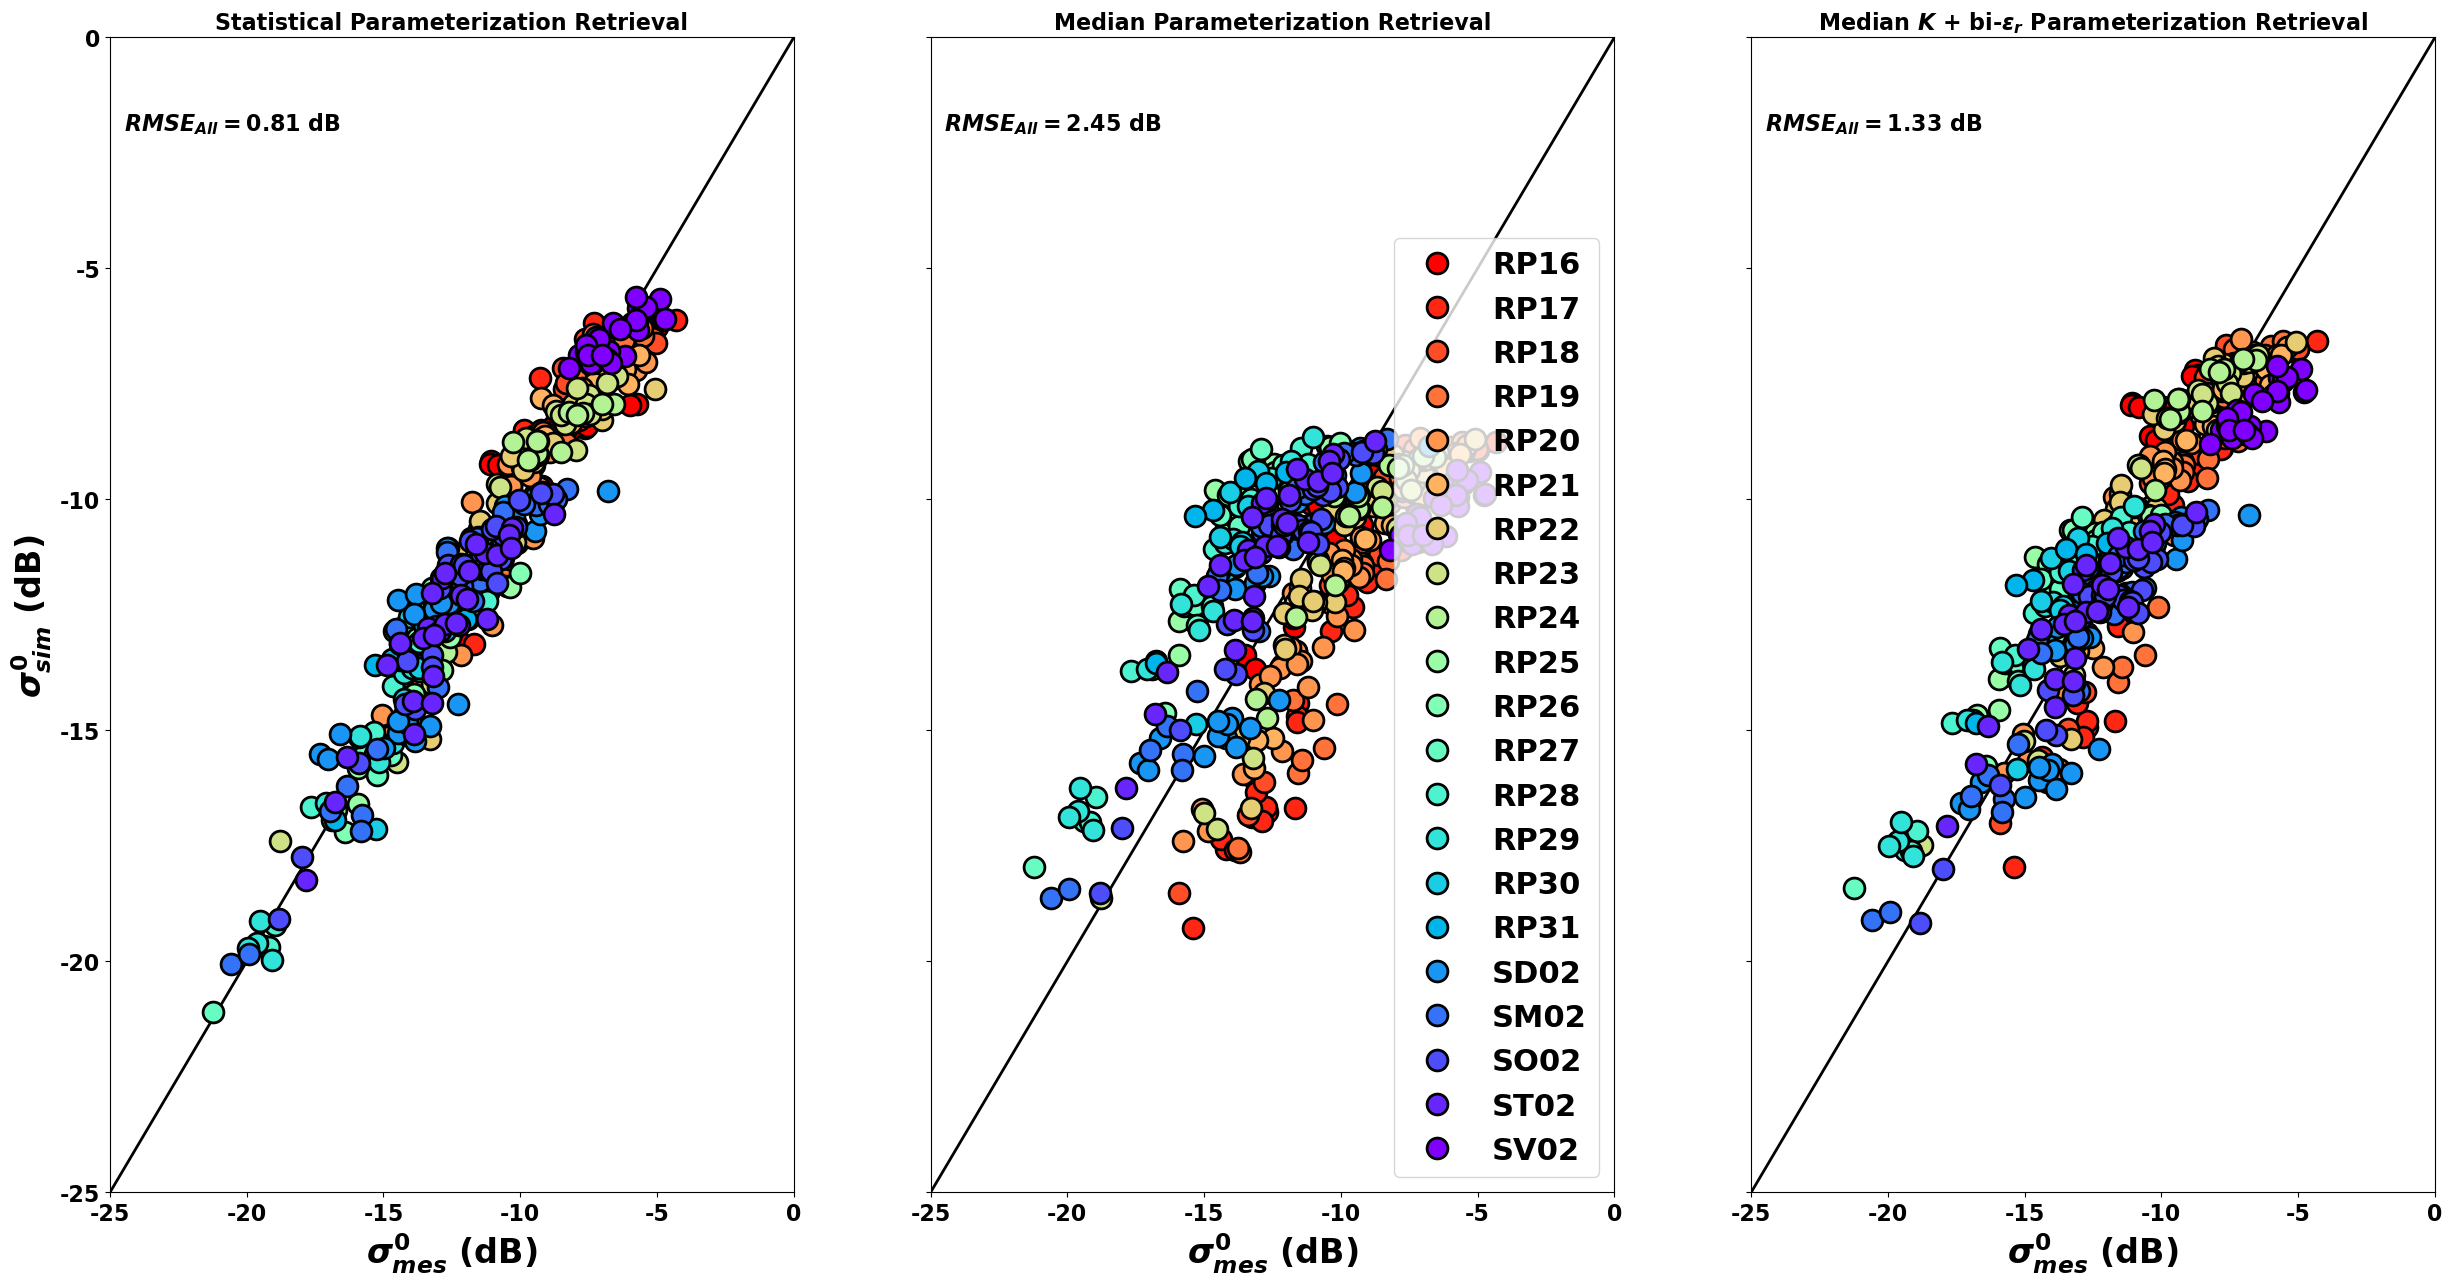

In [108]:
cmap = plt.get_cmap('rainbow')

colors = cmap(np.linspace(0,1,len(sites)))[::-1]

fig, ax = plt.subplots(1,3,figsize=(30, 15))

ax[0].plot([-45, 5],[-45, 5],'-k',linewidth=2)
ax[1].plot([-45, 5],[-45, 5],'-k',linewidth=2)
ax[2].plot([-45, 5],[-45, 5],'-k',linewidth=2)

i=0

deltas=[]
deltas_med=[]
deltas_med2=[]

for site in sites:

    j=0
    delta=[]
    delta_all=[]
    
    if j==0:
        
        ax[0].plot(to_dB(sig0[ku_sites==site]), to_dB(sim_sig02[site].sig0),
                'o', markersize=15, markerfacecolor=colors[i], markeredgecolor='k',  markeredgewidth=2,
                label=site,alpha=1)
        ax[1].plot(to_dB(sig0[ku_sites==site]), to_dB(sim_sig02['med'][site].sig0),
                'o', markersize=15, markerfacecolor=colors[i], markeredgecolor='k',  markeredgewidth=2,
                label=site,alpha=1)
        ax[2].plot(to_dB(sig0[ku_sites==site]), to_dB(sim_sig02['med-dual'][site].sig0),
                'o', markersize=15, markerfacecolor=colors[i], markeredgecolor='k',  markeredgewidth=2,
                label=site,alpha=1)
        
        
    else:
        
        ax[0].plot(to_dB(sig0[ku_sites==site]), to_dB(sim_sig02[site].sig0),
                'o', markersize=15, markerfacecolor=colors[i], markeredgecolor='k',  markeredgewidth=2,
                label='',alpha=1)
        ax[1].plot(to_dB(sig0[ku_sites==site]), to_dB(sim_sig02['med'][site].sig0),
                'o', markersize=15, markerfacecolor=colors[i], markeredgecolor='k',  markeredgewidth=2,
                label='',alpha=1)
        ax[2].plot(to_dB(sig0[ku_sites==site]), to_dB(sim_sig02['med-dual'][site].sig0),
                'o', markersize=15, markerfacecolor=colors[i], markeredgecolor='k',  markeredgewidth=2,
                label='',alpha=1)
        
        
    j+=1

    deltas.extend((to_dB(sig0[ku_sites==site]).values-
                                to_dB(sim_sig02[site].sig0.values)))
    deltas_med.extend((to_dB(sig0[ku_sites==site]).values-
                                to_dB(sim_sig02['med'][site].sig0.values)))
    deltas_med2.extend((to_dB(sig0[ku_sites==site]).values-
                                to_dB(sim_sig02['med-dual'][site].sig0.values)))
    
    delta = np.sqrt(np.mean((to_dB(sig0[ku_sites==site]).values-
                                to_dB(sim_sig02[site].sig0.values))**2))
    delta_med = np.sqrt(np.mean((to_dB(sig0[ku_sites==site]).values-
                                to_dB(sim_sig02['med'][site].sig0.values))**2))
    delta_med2 = np.sqrt(np.mean((to_dB(sig0[ku_sites==site]).values-
                                to_dB(sim_sig02['med-dual'][site].sig0.values))**2))
        
    i+=1

ax[0].text(-24.5,-2,'$RMSE_{All}=$' + "{:.2f}".format(np.sqrt(np.mean(np.array(deltas)**2))) + ' dB',fontsize=16)
ax[1].text(-24.5,-2,'$RMSE_{All}=$' + "{:.2f}".format(np.sqrt(np.mean(np.array(deltas_med)**2))) + ' dB',fontsize=16)
ax[2].text(-24.5,-2,'$RMSE_{All}=$' + "{:.2f}".format(np.sqrt(np.mean(np.array(deltas_med2)**2))) + ' dB',fontsize=16)
ax[0].set_xlabel('$\sigma^0_{mes}$ (dB)', fontsize=24, fontweight='bold')
ax[1].set_xlabel('$\sigma^0_{mes}$ (dB)', fontsize=24, fontweight='bold')
ax[2].set_xlabel('$\sigma^0_{mes}$ (dB)', fontsize=24, fontweight='bold')
ax[0].set_ylabel('$\sigma^0_{sim}$ (dB)', fontsize=24, fontweight='bold')
ax[0].set_ylim([-25,0])
ax[0].set_yticks(np.arange(-25,1,5))
ax[0].set_yticklabels(np.arange(-25,1,5).tolist(), fontsize=16, fontweight='bold')
ax[0].set_xlim([-25,0])
ax[0].set_xticks(np.arange(-25,1,5))
ax[0].set_xticklabels(np.arange(-25,1,5).tolist(), fontsize=16, fontweight='bold')
ax[1].set_ylim([-25,0])
ax[1].set_yticks(np.arange(-25,1,5))
ax[1].set_yticklabels('', fontsize=16, fontweight='bold')
ax[1].set_xlim([-25,0])
ax[1].set_xticks(np.arange(-25,1,5))
ax[1].set_xticklabels(np.arange(-25,1,5).tolist(), fontsize=16, fontweight='bold')
ax[2].set_ylim([-25,0])
ax[2].set_yticks(np.arange(-25,1,5))
ax[2].set_yticklabels('', fontsize=16, fontweight='bold')
ax[2].set_xlim([-25,0])
ax[2].set_xticks(np.arange(-25,1,5))
ax[2].set_xticklabels(np.arange(-25,1,5).tolist(), fontsize=16, fontweight='bold')
ax[0].set_title('Statistical Parameterization Retrieval', fontsize = 16, fontweight = 'bold')
ax[1].set_title('Median Parameterization Retrieval', fontsize = 16, fontweight = 'bold')
ax[2].set_title('Median $K$ + bi-$\\epsilon''_r$ Parameterization Retrieval', fontsize = 16, fontweight = 'bold')
ax[1].legend(loc=4)

<center><img src="Figures/Part_8_KuOpti_Fig1.png" Width="1000px"></center>

<center>Figure : Same as Figure 13 of [Montpetit et al., (2024)](link TBD) but with a 2 layer statistically representative snowpack.</center>

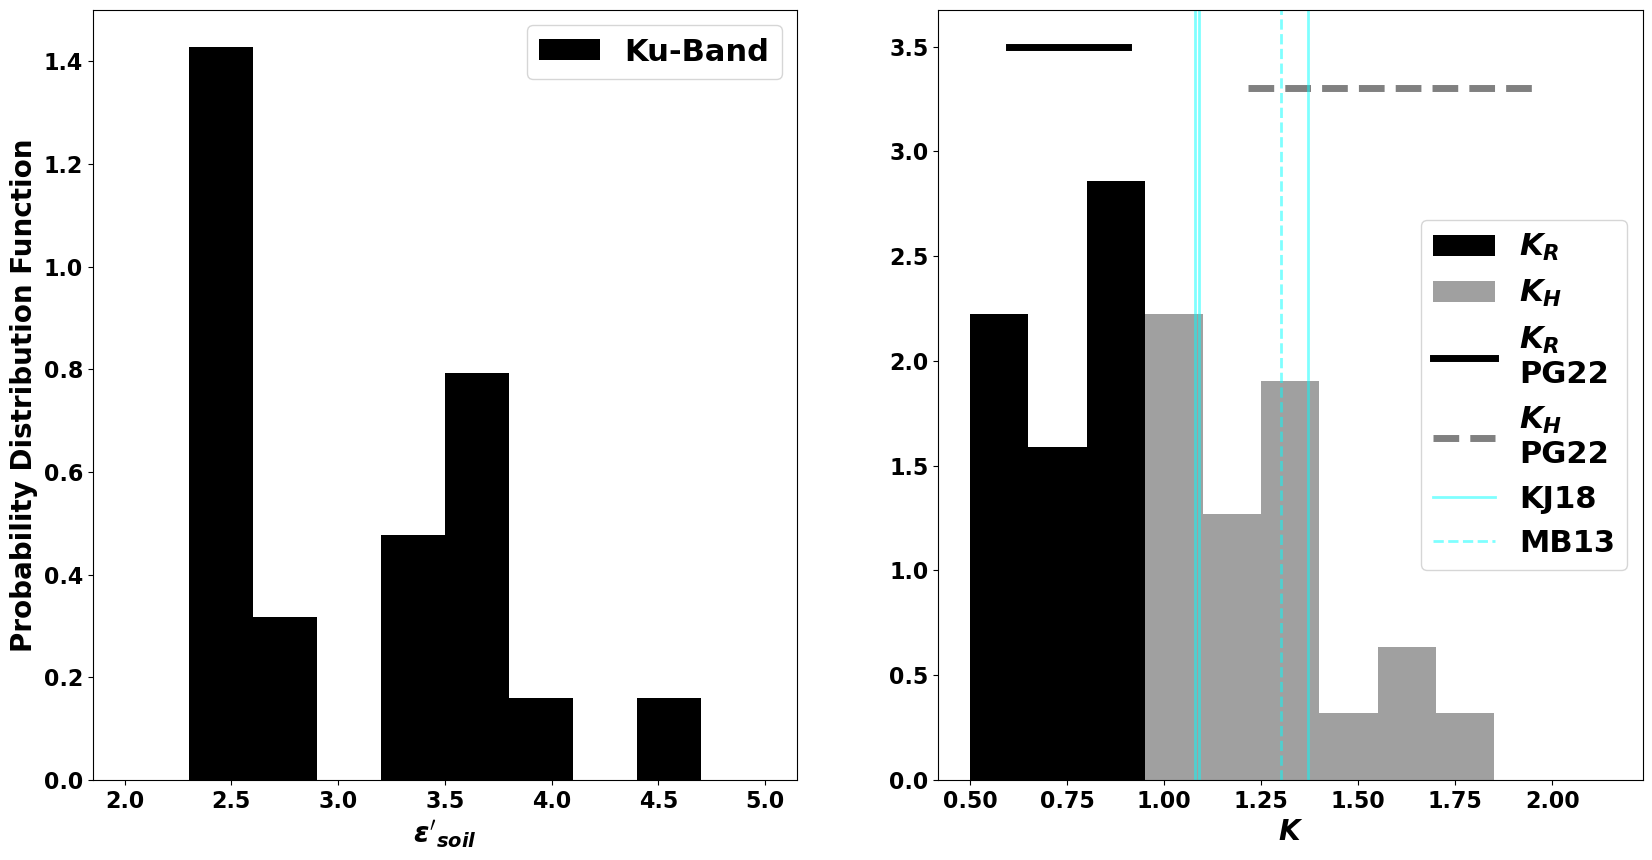

In [109]:
fig, ax = plt.subplots(1,2,figsize=(20, 10))

ax[0].hist(df2.iloc[:-2].epsr_ku, bins=np.arange(2,5.3,0.3), density=True, label = 'Ku-Band', color='k')
ax[1].hist(df2.iloc[:-2].kappa_r, bins=np.arange(0.5,2.2,0.15), density=True, label = '$K_R$', color='k')
ax[1].hist(df2.iloc[:-2].kappa_h, bins=np.arange(0.5,2.2,0.15), density=True, label = '$K_H$', color='grey', alpha=0.75)
ax[1].axhline(3.5, xmin=0.1, xmax=0.27, linestyle='-', color='k', label='$K_R$ \nPG22',linewidth=5)
ax[1].axhline(3.3, xmin=0.44, xmax=0.85, linestyle='--', color='grey', label='$K_H$ \nPG22',linewidth=5)
ax[1].axvline(1.08, linestyle='-', color='cyan', label='KJ18',linewidth=2,alpha=0.5)
ax[1].axvline(1.09, linestyle='-', color='cyan',linewidth=2,alpha=0.5)
ax[1].axvline(1.37, linestyle='-', color='cyan',linewidth=2,alpha=0.5)
ax[1].axvline(1.3, linestyle='--', color='cyan', label='MB13',linewidth=2,alpha=0.5)

ax[0].set_ylabel('Probability Distribution Function', fontsize=20, fontweight='bold')
ax[0].set_xlabel('$\epsilon\'_{soil}$', fontsize=20, fontweight='bold')
ax[1].set_xlabel('$K$', fontsize=20, fontweight='bold')
ax[0].legend()
ax[1].legend()


<center><img src="Figures/Part_8_KuOpti_Fig2.png" Width="1000px"></center>

<center>Figure : Same as Figure 12 of [Montpetit et al., (2024)](link TBD) but with a 2 layer statistically representative snowpack.</center>